<h1 style="font-size:3rem; color: darkmagenta;">Data Aggregation and Group Operations:</h1>

<h1 style="font-size:2.3rem; color: darkcyan;">10.2 Data Aggregation:</h1>

## Table of Contents

- 10.21  **[Data Aggregation](#Aggregation)**
   
- 10.22  **[Column-Wise and Multiple Function Application](#Column-Wise)**

- 10.23  **[Returning Aggregated Data Without Row Indexes](#Returning)**

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore") 

<a id="Aggregation"></a>
## 10.21 Data Aggregation

Aggregations refer to any data transformation that produces scalar values from arrays. The preceding examples have used several of them, including `mean`, `count`, `min`, and `sum`. You may wonder what is going on when you invoke `mean()` on a `GroupBy` object. Many common aggregations, such as those found in Table 10-1, have optimized implementations. However, you are not limited to only this set of methods.

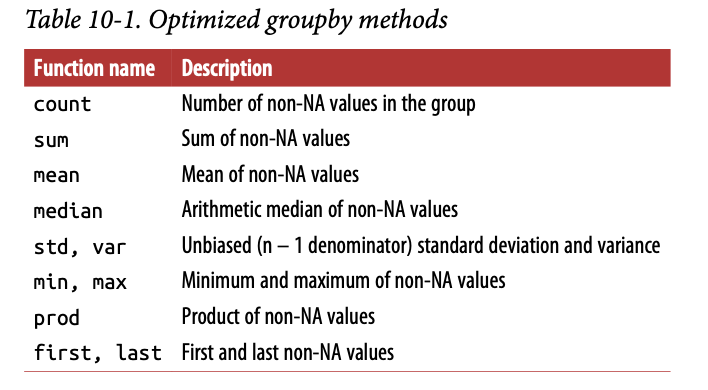

You can use aggregations of your own devising and additionally call any method that is also defined on the grouped object. For example, you might recall that `quantile` computes sample quantiles of a Series or a DataFrame’s columns.

While `quantile` is not explicitly implemented for GroupBy, it is a Series method and thus available for use. Internally, GroupBy efficiently slices up the Series, calls `piece.quantile(0.9)` for each piece, and then assembles those results together into the result object:

In [3]:
df = pd.DataFrame({'key1' : ['a', 'a', 'b', 'b', 'a'],
                   'key2' : ['one', 'two', 'one', 'two', 'one'],
                   'data1' : np.random.randn(5),
                   'data2' : np.random.randn(5)})
df

,key1,key2,data1,data2
0,a,one,0.433723,0.538866
1,a,two,-0.789884,0.230533
2,b,one,-0.038075,0.424344
3,b,two,1.718187,1.675288
4,a,one,0.911267,-0.069985


In [5]:
grouped = df.groupby('key1')
grouped

In [6]:
grouped['data1'].quantile(0.9)

key1
a    0.815758
b    1.542561
Name: data1, dtype: float64

To use your own aggregation functions, pass any function that aggregates an array to the `aggregate` or `agg` method:

In [9]:
def peak_to_peak(arr):
    return arr.max() - arr.min()
grouped.agg(peak_to_peak)

,data1,data2
key1,,
a,1.701151,0.608851
b,1.756262,1.250943


You may notice that some methods like `describe` also work, even though they are not aggregations, strictly speaking:

In [10]:
grouped.describe()

data1                                                              \
     count      mean       std       min       25%       50%       75%   
key1                                                                     
a      3.0  0.185035  0.877418 -0.789884 -0.178080  0.433723  0.672495   
b      2.0  0.840056  1.241865 -0.038075  0.400991  0.840056  1.279122   

               data2                                                    \
           max count      mean       std       min       25%       50%   
key1                                                                     
a     0.911267   3.0  0.233138  0.304434 -0.069985  0.080274  0.230533   
b     1.718187   2.0  1.049816  0.884550  0.424344  0.737080  1.049816   

                          
           75%       max  
key1                      
a     0.384699  0.538866  
b     1.362552  1.675288

Note: Custom aggregation functions are generally much slower than the optimized functions found in Table 10-1. This is because there is some extra overhead (function calls, data rearrangement) in constructing the intermediate group data chunks.

<a id="Column-Wise"></a>
## 10.22 Column-Wise and Multiple Function Application

Let’s return to the tipping dataset from earlier examples. After loading it with `read_csv`, we add a tipping percentage column `tip_pct`:

In [11]:
tips = pd.read_csv('tips.csv')

In [12]:
tips['tip_pct'] = tips['tip'] / tips['total_bill']

In [13]:
tips

,total_bill,tip,smoker,day,time,size,tip_pct
0,16.99,1.01,No,Sun,Dinner,2,0.059447
1,10.34,1.66,No,Sun,Dinner,3,0.160542
2,21.01,3.50,No,Sun,Dinner,3,0.166587
3,23.68,3.31,No,Sun,Dinner,2,0.139780
4,24.59,3.61,No,Sun,Dinner,4,0.146808
...,...,...,...,...,...,...,...
239,29.03,5.92,No,Sat,Dinner,3,0.203927
240,27.18,2.00,Yes,Sat,Dinner,2,0.073584
241,22.67,2.00,Yes,Sat,Dinner,2,0.088222
242,17.82,1.75,No,Sat,Dinner,2,0.098204


As you’ve already seen, aggregating a Series or all of the columns of a DataFrame is a matter of using `aggregate` with the desired function or calling a method like `mean` or `std`. However, you may want to aggregate using a different function depending on the column, or multiple functions at once. Fortunately, this is possible to do, which I’ll illustrate through a number of examples. First, I’ll group the `tips` by `day` and `smoker`:

In [14]:
grouped = tips.groupby(['day', 'smoker'])

Note that for descriptive statistics like those in Table 10-1, you can pass the name of
the function as a string:

In [16]:
grouped_pct = grouped['tip_pct']

In [17]:
grouped_pct.agg('mean')

day   smoker
Fri   No        0.151650
      Yes       0.174783
Sat   No        0.158048
      Yes       0.147906
Sun   No        0.160113
      Yes       0.187250
Thur  No        0.160298
      Yes       0.163863
Name: tip_pct, dtype: float64

If you pass a list of functions or function names instead, you get back a DataFrame with column names taken from the functions:

In [18]:
grouped_pct.agg(['mean', 'std', peak_to_peak])

mean       std  peak_to_peak
day  smoker                                  
Fri  No      0.151650  0.028123      0.067349
     Yes     0.174783  0.051293      0.159925
Sat  No      0.158048  0.039767      0.235193
     Yes     0.147906  0.061375      0.290095
Sun  No      0.160113  0.042347      0.193226
     Yes     0.187250  0.154134      0.644685
Thur No      0.160298  0.038774      0.193350
     Yes     0.163863  0.039389      0.151240

Here we passed a list of aggregation functions to `agg` to evaluate indepedently on the data groups.

You don’t need to accept the names that GroupBy gives to the columns; notably, `lambda` functions have the name '<lambda>', which makes them hard to identify (you can see for yourself by looking at a function’s __name__ attribute). Thus, if you pass a list of (`name`, `function`) tuples, the first element of each tuple will be used as the DataFrame column names (you can think of a list of 2-tuples as an ordered mapping):

In [19]:
grouped_pct.agg([('foo', 'mean'), ('bar', np.std)])

foo       bar
day  smoker                    
Fri  No      0.151650  0.028123
     Yes     0.174783  0.051293
Sat  No      0.158048  0.039767
     Yes     0.147906  0.061375
Sun  No      0.160113  0.042347
     Yes     0.187250  0.154134
Thur No      0.160298  0.038774
     Yes     0.163863  0.039389

With a DataFrame you have more options, as you can specify a list of functions to apply to all of the columns or different functions per column. To start, suppose we wanted to compute the same three statistics for the `tip_pct` and `total_bill` columns:

In [21]:
functions = ['count', 'mean', 'max']
result = grouped['tip_pct', 'total_bill'].agg(functions)
result

tip_pct                     total_bill                  
              count      mean       max      count       mean    max
day  smoker                                                         
Fri  No           4  0.151650  0.187735          4  18.420000  22.75
     Yes         15  0.174783  0.263480         15  16.813333  40.17
Sat  No          45  0.158048  0.291990         45  19.661778  48.33
     Yes         42  0.147906  0.325733         42  21.276667  50.81
Sun  No          57  0.160113  0.252672         57  20.506667  48.17
     Yes         19  0.187250  0.710345         19  24.120000  45.35
Thur No          45  0.160298  0.266312         45  17.113111  41.19
     Yes         17  0.163863  0.241255         17  19.190588  43.11

As you can see, the resulting DataFrame has hierarchical columns, the same as you would get aggregating each column separately and using `concat` to glue the results together using the column names as the `keys` argument:

In [22]:
result['tip_pct']

count      mean       max
day  smoker                           
Fri  No          4  0.151650  0.187735
     Yes        15  0.174783  0.263480
Sat  No         45  0.158048  0.291990
     Yes        42  0.147906  0.325733
Sun  No         57  0.160113  0.252672
     Yes        19  0.187250  0.710345
Thur No         45  0.160298  0.266312
     Yes        17  0.163863  0.241255

As before, a list of tuples with custom names can be passed:

In [23]:
ftuples = [('Durchschnitt', 'mean'), ('Abweichung', np.var)]

In [24]:
grouped['tip_pct', 'total_bill'].agg(ftuples)

tip_pct              total_bill            
            Durchschnitt Abweichung Durchschnitt  Abweichung
day  smoker                                                 
Fri  No         0.151650   0.000791    18.420000   25.596333
     Yes        0.174783   0.002631    16.813333   82.562438
Sat  No         0.158048   0.001581    19.661778   79.908965
     Yes        0.147906   0.003767    21.276667  101.387535
Sun  No         0.160113   0.001793    20.506667   66.099980
     Yes        0.187250   0.023757    24.120000  109.046044
Thur No         0.160298   0.001503    17.113111   59.625081
     Yes        0.163863   0.001551    19.190588   69.808518

Now, suppose you wanted to apply potentially different functions to one or more of the columns. To do this, pass a dict to `agg` that contains a mapping of column names to any of the function specifications listed so far:

In [25]:
grouped.agg({'tip' : np.max, 'size' : 'sum'})

tip  size
day  smoker             
Fri  No       3.50     9
     Yes      4.73    31
Sat  No       9.00   115
     Yes     10.00   104
Sun  No       6.00   167
     Yes      6.50    49
Thur No       6.70   112
     Yes      5.00    40

In [26]:
grouped.agg({'tip_pct' : ['min', 'max', 'mean', 'std'],
            'size' : 'sum'})

tip_pct                               size
                  min       max      mean       std  sum
day  smoker                                             
Fri  No      0.120385  0.187735  0.151650  0.028123    9
     Yes     0.103555  0.263480  0.174783  0.051293   31
Sat  No      0.056797  0.291990  0.158048  0.039767  115
     Yes     0.035638  0.325733  0.147906  0.061375  104
Sun  No      0.059447  0.252672  0.160113  0.042347  167
     Yes     0.065660  0.710345  0.187250  0.154134   49
Thur No      0.072961  0.266312  0.160298  0.038774  112
     Yes     0.090014  0.241255  0.163863  0.039389   40

A DataFrame will have hierarchical columns only if multiple functions are applied to at least one column.

<a id="Returning"></a>
## 10.23 Returning Aggregated Data Without Row Indexes

In all of the examples up until now, the aggregated data comes back with an index, potentially hierarchical, composed from the unique group key combinations. Since this isn’t always desirable, you can disable this behavior in most cases by passing `as_index=False` to `groupby`:

In [28]:
tips.groupby(['day', 'smoker'], as_index=False).mean()

,day,smoker,total_bill,tip,size,tip_pct
0,Fri,No,18.420000,2.812500,2.250000,0.151650
1,Fri,Yes,16.813333,2.714000,2.066667,0.174783
2,Sat,No,19.661778,3.102889,2.555556,0.158048
3,Sat,Yes,21.276667,2.875476,2.476190,0.147906
4,Sun,No,20.506667,3.167895,2.929825,0.160113
5,Sun,Yes,24.120000,3.516842,2.578947,0.187250
6,Thur,No,17.113111,2.673778,2.488889,0.160298
7,Thur,Yes,19.190588,3.030000,2.352941,0.163863


Of course, it’s always possible to obtain the result in this format by calling `reset_index` on the result. Using the `as_index=False` method avoids some unnecessary computations.